In [170]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [171]:
%cd /content/drive/MyDrive/bioinformatics

/content/drive/MyDrive/bioinformatics


In [172]:
import itertools
import os
import random
import shutil
import time
from tqdm.notebook import tqdm
import uuid
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt

In [173]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [174]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

# Config

In [175]:
TRAIN_ON_TF = 'TF_2'
TRAIN_PROBE = 'A'
TEST_PROBE = 'B'
MOTIF_LEN = 24
NUM_MOTIF_DETECTORS=10
BATCH_SIZE = 64
MODEL_NAME = "residual"
DROPOUT = 0.7
LR = 2e-4
WEIGHT_DECAY = 5e-4

In [176]:
DNA_BASES = 'ACGT'
RNA_BASES = 'ACGU'

In [177]:
PBM_DATA = "./data/dream5/pbm"

# Data preparation

### Read DREAM5 sequence data with binding scores

In [178]:
df_seq = pd.read_csv(f"{PBM_DATA}/sequences.tsv", sep='\t')
df_seq.head()

,Fold ID,Event ID,seq
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT


In [179]:
df_targets = pd.read_csv(f"{PBM_DATA}/targets.tsv", sep='\t')
df_targets.head()

,TF_40,TF_41,TF_42,TF_43,TF_44,TF_45,TF_46,TF_47,TF_48,TF_49,...,C_19,C_18,C_15,C_14,C_17,C_16,C_11,C_10,C_13,C_12
0,823.914118,12702.625538,2124.023125,2314.305782,1474.888697,1131.785521,4597.003319,14589.890994,1556.951404,34180.775942,...,1651.254953,1242.303363,724.105850,3184.883349,8935.394363,12689.558779,4102.312624,505.126184,12946.381724,1313.790253
1,1307.840222,4316.426121,2554.658908,3415.320661,3408.586803,1697.342725,5272.763446,22903.130555,2181.551097,10000.297243,...,3505.604759,2516.000120,1640.114829,3463.713253,19535.468264,18006.721690,6890.427794,1402.597000,38309.856355,3024.107809
2,1188.353499,3436.803941,2088.909658,3708.324021,2219.741833,1571.646567,6225.376501,13858.014077,1971.053716,18800.025304,...,3270.572883,1693.419147,997.792996,3196.992198,16695.027604,14486.992627,13517.968701,10680.866586,25648.825592,2675.530918
3,1806.103795,6531.268855,2406.186212,3601.204703,2828.415329,2746.861783,5810.104650,25701.749693,2191.273065,19213.880658,...,2701.555739,2059.614815,1432.163042,4927.163643,18896.765835,18784.043322,8608.167421,4624.044391,23651.726053,3679.449867
4,1417.411525,3951.243575,2581.309532,3375.884699,2764.716964,1806.919566,5033.976283,26364.859152,2311.790793,16139.097553,...,2457.214141,1901.709222,1672.531034,3877.787322,14699.253953,17119.871513,8995.328144,12641.425965,27999.405431,3128.844808


### Build a dataframe for single transcription factor

In [180]:
def build_df(tf, df_seq, df_targets):
    df = df_seq.copy()
    df["Target"] = df_targets[tf].values
    return df

In [181]:
df = build_df(TRAIN_ON_TF, df_seq, df_targets)
df.head()

,Fold ID,Event ID,seq,Target
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598


In [182]:
df['Target'].mean()

np.float64(4223.027893532134)

In [183]:
df['Target'].std()

4568.640213013829

### Remove probe specific biases for each sequence

In [184]:
biases = df_targets.median(axis=1).values
biases

array([2641.988164 , 4170.2475   , 3699.8877625, ..., 2287.3149815,
       1884.915039 , 1231.9427485])

In [185]:
df['TargetNorm'] = df['Target'].values / biases
df.head()

,Fold ID,Event ID,seq,Target,TargetNorm
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352,1.113377
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089,1.593671
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308,1.245141
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206,1.758181
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598,2.046512


### Calculate NA content and drop rows

In [186]:
# Only 4% NA content, it is safe to drop the rows
df['Target'].isna().mean()

np.float64(0.04049173839912932)

In [187]:
df.dropna(subset=['Target'], inplace=True)
df['Target'].isna().mean()

np.float64(0.0)

### Train/Test data split

In [188]:
df_train = df[df['Fold ID'] == TRAIN_PROBE]
df_train.head()

,Fold ID,Event ID,seq,Target,TargetNorm
40526,A,HK26479,ACGCGCGTCAGCTTTTTGGAATATTGCGGAGAGTTCCTGT,1894.891681,0.713724
40527,A,HK26478,GACTATGGGATGGGCCGCCTTTGATTACGCGCGTCCCTGT,3041.923394,1.000000
40528,A,HK22998,CCTTCGTGAGCCATGTGTTTCAGGCTGTGCGTGTCCCTGT,1876.956557,0.790750
40529,A,HK22999,GGCGGGTGGTAAAGGCCCCGGAAGCGGACACGCACCCTGT,1048.948759,0.622457
40530,A,HK26473,GTTGTGGTTTGTCCTTTTGTATTAACAGTGTATGGCCTGT,2343.217193,0.626426


In [189]:
df_test = df[df['Fold ID'] == TEST_PROBE]
df_test.head()

,Fold ID,Event ID,seq,Target,TargetNorm
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352,1.113377
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089,1.593671
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308,1.245141
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206,1.758181
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598,2.046512


In [190]:
df_train.shape, df_test.shape

((38041, 5), (39541, 5))

### Add labels for ROC and AUC

In [191]:
# DREAM5 https://pmc.ncbi.nlm.nih.gov/articles/PMC3687085/
def add_label(d):
    # Add positive label to only rows with binding score higher than mean + 4*std
    mean = d['Target'].mean()
    std = d['Target'].std()
    lower_limit = mean + 4*std

    # Limits MAX: 1300 rows MIN: 50 rows
    top = d[d['Target'] > lower_limit].copy()
    if len(top) >= 50:
        top = top.sort_values(by='Target', ascending=False).head(1300)
    else:
        top = d.sort_values(by='Target', ascending=False, inplace=False).head(50)

    d['Label'] = 0
    d.loc[top.index, 'Label'] = 1

In [192]:
add_label(df_train)
df_train.head()

/tmp/ipython-input-1025513887.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['Label'] = 0


,Fold ID,Event ID,seq,Target,TargetNorm,Label
40526,A,HK26479,ACGCGCGTCAGCTTTTTGGAATATTGCGGAGAGTTCCTGT,1894.891681,0.713724,0
40527,A,HK26478,GACTATGGGATGGGCCGCCTTTGATTACGCGCGTCCCTGT,3041.923394,1.000000,0
40528,A,HK22998,CCTTCGTGAGCCATGTGTTTCAGGCTGTGCGTGTCCCTGT,1876.956557,0.790750,0
40529,A,HK22999,GGCGGGTGGTAAAGGCCCCGGAAGCGGACACGCACCCTGT,1048.948759,0.622457,0
40530,A,HK26473,GTTGTGGTTTGTCCTTTTGTATTAACAGTGTATGGCCTGT,2343.217193,0.626426,0


In [193]:
df_train[df_train['Label'] == 1].head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
40545,A,HK37117,ATAGATGATTGCCTAATAGAACCTACACAGTAAACCCTGT,23505.012865,6.751061,1
40630,A,HK39222,AGGTGTTACATATATCAGCTTGGGTGGATACCCGACCTGT,19403.494948,7.323275,1
40751,A,HK31683,GGCATTCAGGACAATTAGATAACCCAAGCGTAGCCCCTGT,20245.802138,8.385751,1
40775,A,HK34305,TGTATTGCATAAACGTTCCAGGACCCCTGGCTCACCCTGT,33224.921774,14.948550,1
40961,A,HK15380,TGTATGATCACCAACTCATGGTTGCGCAATGAACCCCTGT,22591.018693,7.530934,1


In [194]:
add_label(df_test)
df_test.head()

/tmp/ipython-input-1025513887.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['Label'] = 0


,Fold ID,Event ID,seq,Target,TargetNorm,Label
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352,1.113377,0
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089,1.593671,0
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308,1.245141,0
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206,1.758181,0
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598,2.046512,0


In [195]:
df_test[df_test['Label'] == 1].head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
149,B,MEforward05359,TAAGAAAAGATTTTTACGTAACATGTCTACTCTGGCCTGT,54999.072022,15.626592,1
598,B,MEreverse19582,ATCGAGTCGGCTTTACAATTACATAATCTAAGCTACCTGT,72179.964196,10.621469,1
640,B,MEforward05965,AGCTACATGTAGCTCGGCATTTATATAACCCACTGCCTGT,26433.473625,5.848461,1
769,B,MEreverse06558,ATTCTAACGACTGTGACATAATGACCCCACCTCGGCCTGT,28221.317418,5.393725,1
825,B,MEreverse08764,TACGCATTTACGTTGCATAATCTTGTGAGTAGCAGCCTGT,54040.187164,10.802248,1


### DNA/RNA sequence to Matrix logic

In [196]:
def fill_cell(motif_len, row, col, bases, seq):
    num_rows = len(seq) + 2 * motif_len - 2

    # First M-1 rows are filled with 0.25
    if row < motif_len-1:
        return 0.25

    # Last M-1 rows are filled with 0.25
    if num_rows-1-row < motif_len-1:
        return 0.25

    idx = row - motif_len + 1
    if seq[idx] == bases[col]:
        return 1.0

    return 0.0

def seq2matrix(seq, motif_len, typ='DNA'):
    bases = DNA_BASES if typ == 'DNA' else RNA_BASES
    num_rows = len(seq) + 2 * motif_len - 2
    result = np.empty([num_rows, 4])
    for row in range(num_rows):
        for col in range(4):
            result[row, col] = fill_cell(motif_len, row, col, bases, seq)
    return np.transpose(result)

In [197]:
# Test the function
S = seq2matrix("ATGG", 3, 'DNA')
S

array([[0.25, 0.25, 1.  , 0.  , 0.  , 0.  , 0.25, 0.25],
       [0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.25, 0.25],
       [0.25, 0.25, 0.  , 0.  , 1.  , 1.  , 0.25, 0.25],
       [0.25, 0.25, 0.  , 1.  , 0.  , 0.  , 0.25, 0.25]])

In [198]:
S.shape

(4, 8)

### Sequence Dataset and Loader

In [199]:
class SeqDataset(Dataset):
    def __init__(self, df):
        self.sequences = df['seq'].values
        self.targets = df['TargetNorm'].values
        self.labels = df['Label'].values

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]

        M = seq2matrix(seq, MOTIF_LEN, 'DNA')

        x = torch.tensor(M, dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        label = self.labels[idx].copy()

        return x, y, label

In [200]:
class AugmentedSeqDataset(Dataset):
    def __init__(self, df, motif_len, augment_prob=0.7):
        self.sequences = df['seq'].values
        self.targets = df['TargetNorm'].values
        self.labels = df['Label'].values
        self.motif_len = motif_len
        self.augment_prob = augment_prob

    def __len__(self):
        return len(self.sequences)

    def reverse_complement_seq(self, seq):
        complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
        return ''.join([complement.get(b, b) for b in reversed(seq)])

    def __getitem__(self, idx):
        seq = self.sequences[idx]

        if np.random.random() < self.augment_prob:
            seq = self.reverse_complement_seq(seq)

        M = seq2matrix(seq, self.motif_len, 'DNA')
        x = torch.tensor(M, dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        label = self.labels[idx].copy()

        return x, y, label

In [201]:
train_dataset = AugmentedSeqDataset(df_train, MOTIF_LEN, augment_prob=0.7)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [202]:
xs, ys, labels = [], [], []

for x, y, label in train_dataset:
    xs.append(x)
    ys.append(y)
    labels.append(label)

x_train = torch.stack(xs)
y_train = torch.tensor(ys, dtype=torch.float32)
label_train = torch.tensor(labels)

In [203]:
x, target, label = next(iter(train_loader))
x.shape, target.shape, label.shape

(torch.Size([64, 4, 86]), torch.Size([64]), torch.Size([64]))

In [204]:
test_dataset = SeqDataset(df_test)

xs, ys, labels = [], [], []

for x, y, label in test_dataset:
    xs.append(x)
    ys.append(y)
    labels.append(label)

x_test = torch.stack(xs)
y_test = torch.tensor(ys, dtype=torch.float32)
label_test = torch.tensor(labels)

In [205]:
x_test.shape, y_test.shape, label_test.shape

(torch.Size([39541, 4, 86]), torch.Size([39541]), torch.Size([39541]))

# Model

### DeepBind Model

In [206]:
import torch.nn as nn
import torch.nn.functional as F

class DeepBindShallow(nn.Module):
    def __init__(self, num_motif_detectors, motif_len):
        super().__init__()

        self.conv = nn.Conv1d(in_channels=4, out_channels=num_motif_detectors, kernel_size=motif_len)
        self.fc = nn.Linear(num_motif_detectors, 1)

    def forward(self, x):

        x = self.conv(x)
        x = F.relu(x)
        x, _ = torch.max(x, dim=2)
        x = self.fc(x)

        return x

In [207]:
def reverse_complement(x):
    # x: (B, 4, L)
    # reverse the sequence
    x = torch.flip(x, dims=[2])

    # swap A-T, C-G
    # A C G T → T G C A
    x = x[:, [3, 2, 1, 0], :]

    return x

In [208]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class DeepBindOriginal(nn.Module):
    def __init__(self, num_motif_detectors, motif_len):
        super().__init__()

        self.conv = nn.Conv1d(4, num_motif_detectors, kernel_size=motif_len)

        self.fc1 = nn.Linear(num_motif_detectors, 32)
        self.fc2 = nn.Linear(32, 1)

        self.init_weights(self.conv)
        self.init_weights(self.fc1)
        self.init_weights(self.fc2)

    def init_weights(self, component):
        init.kaiming_normal_(component.weight, nonlinearity='relu')
        init.zeros_(component.bias)

    def forward_pass(self, x):
        x = F.relu(self.conv(x))
        x, _ = torch.max(x, dim=2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward(self, x):
        r = self.forward_pass(x)
        r_comp = self.forward_pass(reverse_complement(x))
        return torch.max(r, r_comp)

In [209]:
class DeepBindDeeper(nn.Module):
    def __init__(self, num_motif_detectors, motif_len, dropout=0.3):
        super().__init__()

        self.conv1 = nn.Conv1d(4, num_motif_detectors, kernel_size=motif_len)
        self.bn1 = nn.BatchNorm1d(num_motif_detectors)

        self.conv2 = nn.Conv1d(num_motif_detectors, num_motif_detectors * 2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(num_motif_detectors * 2)

        self.fc1 = nn.Linear(num_motif_detectors * 2, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(128, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(dropout / 2)

        self.fc4 = nn.Linear(32, 1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)

    def forward_pass(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x, _ = torch.max(x, dim=2)

        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

    def forward(self, x):
        r = self.forward_pass(x)
        r_comp = self.forward_pass(reverse_complement(x))
        return torch.max(r, r_comp)

In [210]:
class DeepBindResidual(nn.Module):
    def __init__(self, num_motif_detectors, motif_len, dropout=0.3):
        super().__init__()

        self.conv1 = nn.Conv1d(4, num_motif_detectors, kernel_size=motif_len)
        self.bn1 = nn.BatchNorm1d(num_motif_detectors)

        self.conv2 = nn.Conv1d(num_motif_detectors, num_motif_detectors, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(num_motif_detectors)

        self.conv3 = nn.Conv1d(num_motif_detectors, num_motif_detectors, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(num_motif_detectors)

        self.fc1 = nn.Linear(num_motif_detectors, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(128, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(128, 64)
        self.bn_fc3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(dropout / 2)

        self.fc4 = nn.Linear(64, 1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)

    def forward_pass(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        identity = x
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = x + identity

        identity = x
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = x + identity

        x, _ = torch.max(x, dim=2)

        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        identity = x
        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = x + identity

        x = self.fc3(x)
        x = self.bn_fc3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

    def forward(self, x):
        r = self.forward_pass(x)
        r_comp = self.forward_pass(reverse_complement(x))
        return torch.max(r, r_comp)

In [211]:
def get_model(model_name, num_motif_detectors=16, motif_len=24, dropout=0.3):
    models = {
        'original': DeepBindOriginal,
        'deeper': DeepBindDeeper,
        'residual': DeepBindResidual,
    }

    if model_name not in models:
        raise ValueError(f"Model {model_name} not found. Choose from {list(models.keys())}")

    model_class = models[model_name]

    if model_name == 'original':
        return model_class(num_motif_detectors, motif_len)
    else:
        return model_class(num_motif_detectors, motif_len, dropout)

### Model Wrapper for training

In [212]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class ModelWrapper:
    def __init__(self, model, device='cuda', lr=1e-3, weight_decay=1e-5,
                 use_scheduler=True, use_mixup=False, mixup_alpha=0.2):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr,
                                    weight_decay=weight_decay)
        self.criterion = nn.MSELoss()

        self.use_mixup = use_mixup
        self.mixup_alpha = mixup_alpha

        self.use_scheduler = use_scheduler
        if use_scheduler:
            self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, mode='max', factor=0.5, patience=3
            )

        self.history = {
            'train_loss': [],
            'val_auc': [],
            'val_pearson': [],
            'val_spearman': [],
        }

    def train_step(self, x, target):
        self.model.train()
        x = x.to(self.device)
        target = target.to(self.device)

        if self.use_mixup:
            lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
            batch_size = x.size(0)
            index = torch.randperm(batch_size).to(self.device)
            x = lam * x + (1 - lam) * x[index]
            target = lam * target + (1 - lam) * target[index]

        self.optimizer.zero_grad()
        pred = self.model(x)
        loss = self.criterion(pred.squeeze(), target)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

        self.optimizer.step()

        return loss.item()

    def predict(self, x):
        self.model.eval()
        x = x.to(self.device)
        with torch.no_grad():
            pred = self.model(x).squeeze()
        pred = pred.cpu().numpy()
        return pred

    def evaluate(self, x, y_true, label_true, plot=True):
        y_pred = self.predict(x)

        fpr, tpr, thresholds = roc_curve(label_true, y_pred)
        roc_auc = auc(fpr, tpr)

        pearson_corr, _ = pearsonr(y_true, y_pred)
        spearman_corr, _ = spearmanr(y_true, y_pred)

        if plot:
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
            plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend()
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

        return {
            'pearson': pearson_corr,
            'spearman': spearman_corr,
            'auc': roc_auc,
        }

    def train_one_epoch(self, loader):
        epoch_loss = 0
        for x, y, label in tqdm(loader):
            loss = self.train_step(x, y)
            epoch_loss += loss
        epoch_loss = epoch_loss / len(loader)
        return epoch_loss

    def train(self, train_loader, x_val, y_val, label_val, epochs=30):
        for epoch in range(1, epochs + 1):
            print(f"===== EPOCH {epoch} =====")

            epoch_loss = self.train_one_epoch(train_loader)
            self.history['train_loss'].append(epoch_loss)

            val_metrics = self.evaluate(x_val, y_val, label_val, plot=True)
            self.history['val_auc'].append(val_metrics['auc'])
            self.history['val_pearson'].append(val_metrics['pearson'])
            self.history['val_spearman'].append(val_metrics['spearman'])

            print(f"Loss: {epoch_loss}")

            if self.use_scheduler:
                self.scheduler.step(val_metrics['auc'])

        return self.history

### Sanity Check: Overfit on single mini-batch

In [213]:
x, y, label = next(iter(train_loader))
x.shape, y.shape, label.shape

(torch.Size([64, 4, 86]), torch.Size([64]), torch.Size([64]))

In [214]:
m_sanity = get_model(model_name=MODEL_NAME, num_motif_detectors=NUM_MOTIF_DETECTORS, motif_len=MOTIF_LEN, dropout=DROPOUT)

In [215]:
mw_sanity = ModelWrapper(m_sanity, lr=LR, weight_decay=WEIGHT_DECAY)

In [216]:
for i in range(10000):
    loss = mw_sanity.train_step(x, y)
    if i % 1000 == 0:
        print(loss)

1.304128885269165
0.08152884244918823
0.043395742774009705
0.014201346784830093
0.012424382381141186
0.010499113239347935
0.01181770209223032
0.009780194610357285
0.0069473907351493835
0.008110443130135536


In [217]:
pred_sanity = mw_sanity.predict(x)
pred_sanity[:10]

array([0.56496316, 0.6197304 , 0.85819185, 0.6808481 , 0.9412037 ,
       0.8506805 , 0.59141684, 1.9084283 , 0.6110016 , 0.6094482 ],
      dtype=float32)

In [218]:
target_sanity = y.cpu().numpy()
target_sanity[:10]

array([0.5490033 , 0.63263434, 0.8735827 , 0.68351716, 0.990086  ,
       0.8725017 , 0.6405244 , 1.9474807 , 0.6433608 , 0.6281498 ],
      dtype=float32)

In [219]:
for name, p in mw_sanity.model.named_parameters():
    print(name, p.data.abs().mean().item())

conv1.weight 0.09965378046035767
conv1.bias 4.432642981555546e-06
bn1.weight 0.8771350979804993
bn1.bias 0.02170422673225403
conv2.weight 0.16932973265647888
conv2.bias 1.3030215768594644e-06
bn2.weight 0.8517427444458008
bn2.bias 0.025908082723617554
conv3.weight 0.14406391978263855
conv3.bias 8.356059879588429e-07
bn3.weight 0.8075413107872009
bn3.bias 0.01968418061733246
fc1.weight 0.07174413651227951
fc1.bias 6.105813668000337e-07
bn_fc1.weight 0.3268181383609772
bn_fc1.bias 0.0684351995587349
fc2.weight 0.01124226301908493
fc2.bias 2.80154552001477e-07
bn_fc2.weight 0.19899973273277283
bn_fc2.bias 0.024541102349758148
fc3.weight 0.02112654224038124
fc3.bias 4.211341320115025e-07
bn_fc3.weight 0.38532641530036926
bn_fc3.bias 0.050246696919202805
fc4.weight 0.07227541506290436
fc4.bias 0.5972081422805786


In [220]:
m = get_model(model_name=MODEL_NAME, num_motif_detectors=NUM_MOTIF_DETECTORS, motif_len=MOTIF_LEN, dropout=DROPOUT)

In [221]:
mw = ModelWrapper(m, lr=LR, weight_decay=WEIGHT_DECAY)

### Sanity Check: Reverse compliment

In [222]:
np.allclose(mw.predict(x), mw.predict(reverse_complement(reverse_complement(x))))

True

# Training

In [223]:
def train(mw, loader, epochs):
    for epoch in range(1, epochs+1):
        print(f"===== EPOCH {epoch} =====")
        epoch_loss = mw.train_one_epoch(loader)
        mw.evaluate(x_test, y_test, label_test)
        print(f"Loss: {epoch_loss}")

===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

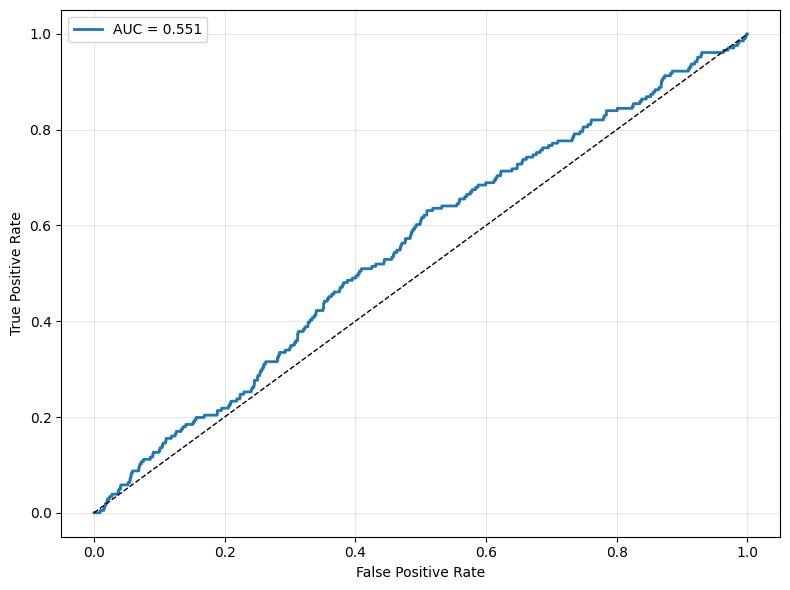

Loss: 2.7977260142815212
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

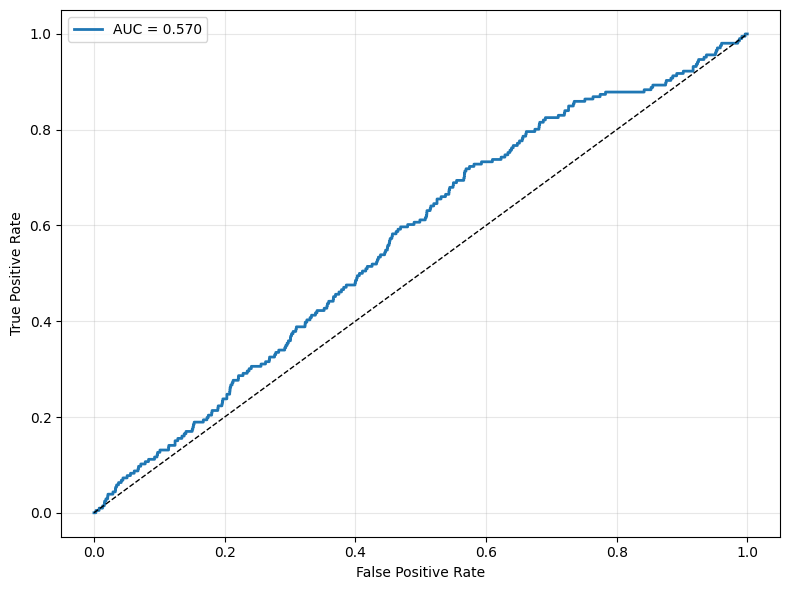

Loss: 2.172949481999674
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

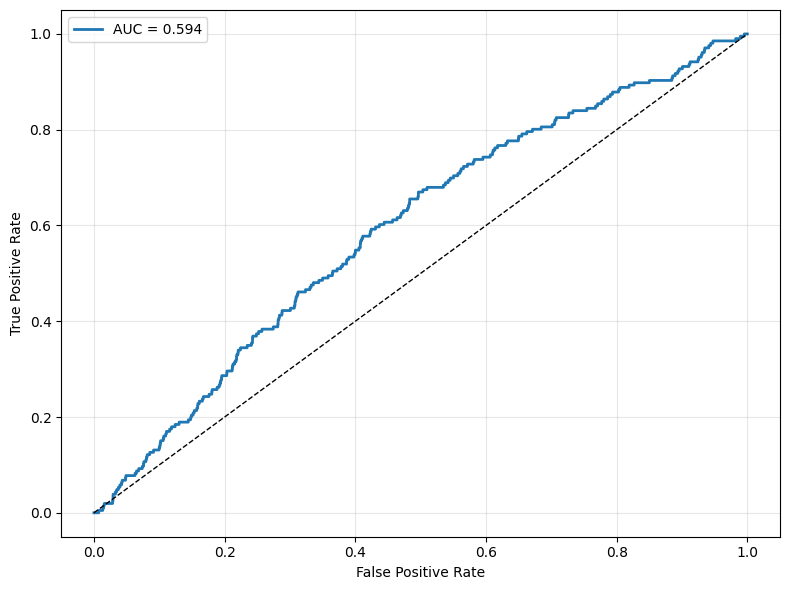

Loss: 2.1199485050905653
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

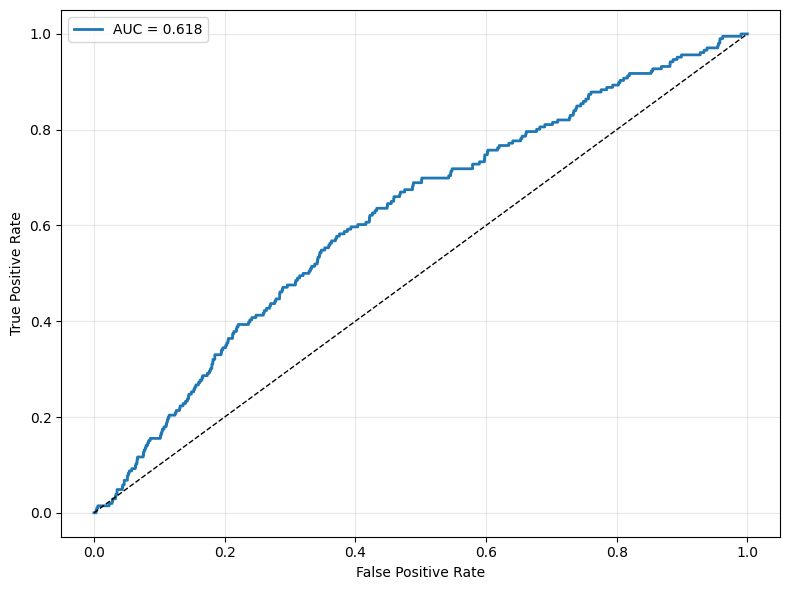

Loss: 2.0538165890494313
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

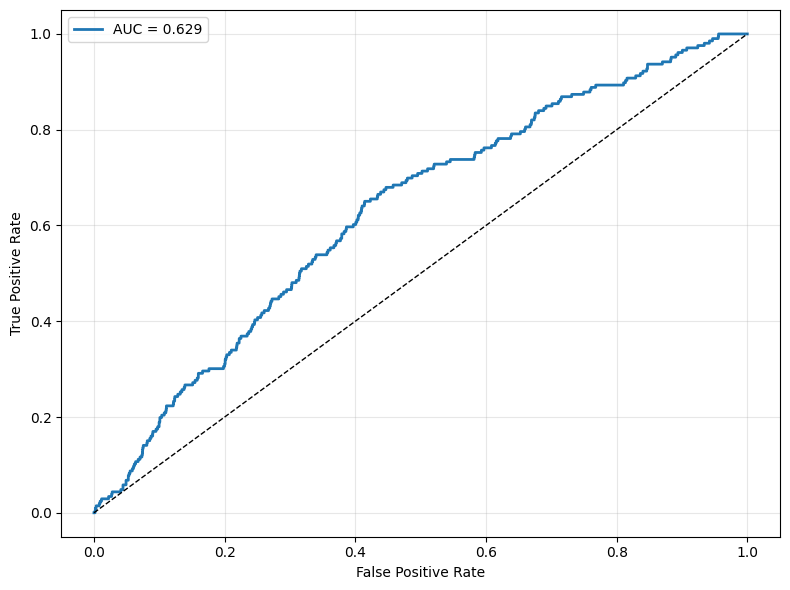

Loss: 2.033533908990251
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

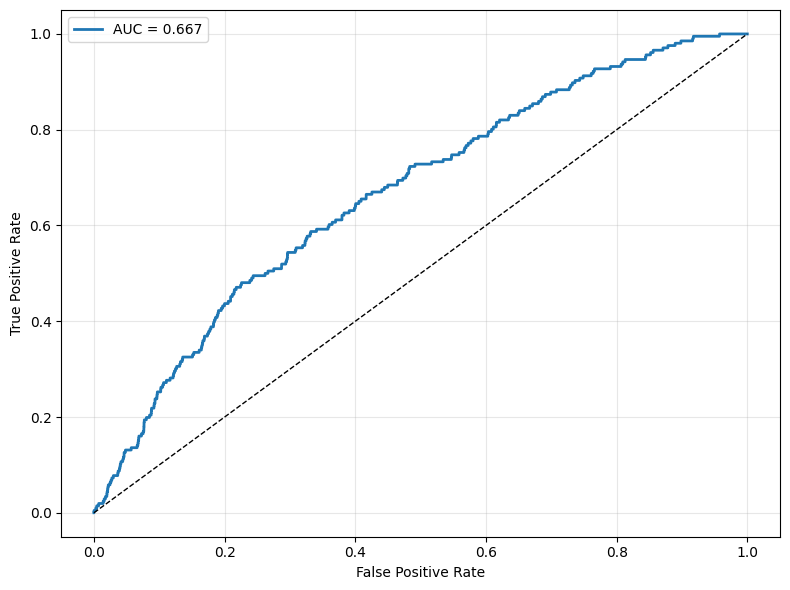

Loss: 2.0193045477218488
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

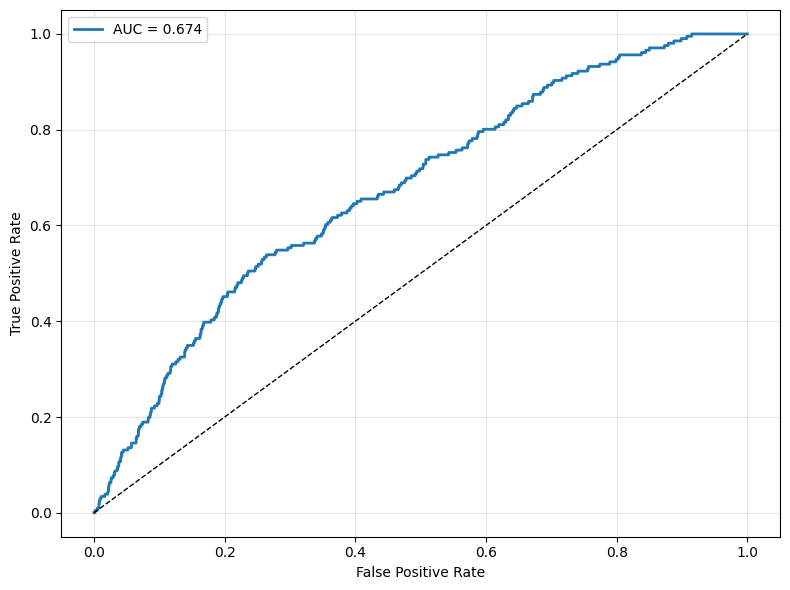

Loss: 2.0123183242162734
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

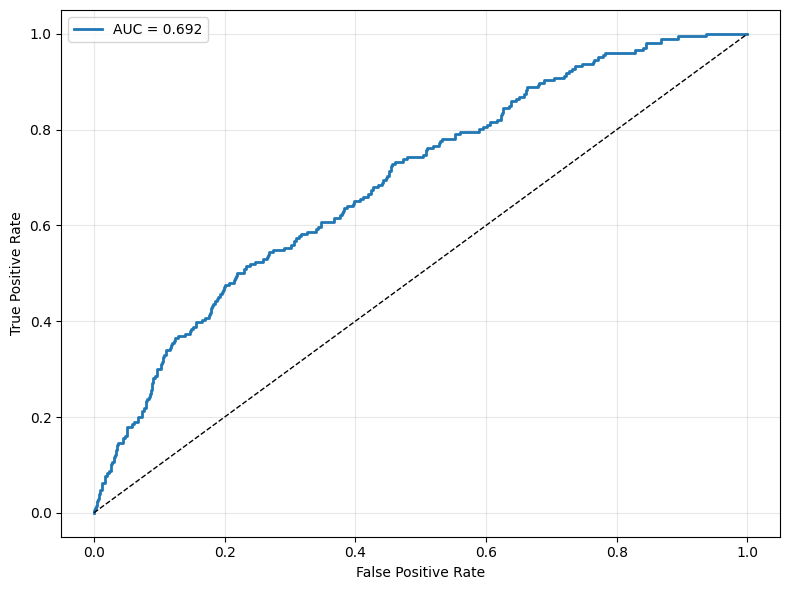

Loss: 2.0040878090788334
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

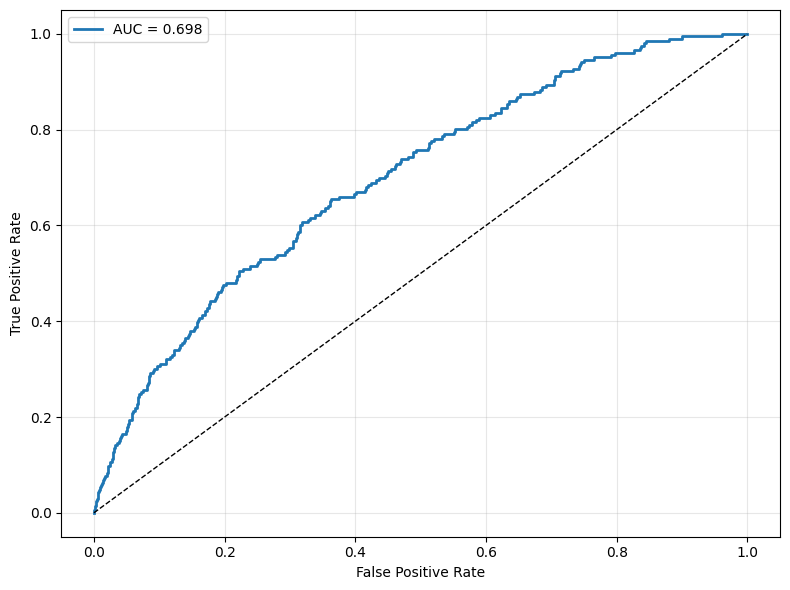

Loss: 2.0030686497844816
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

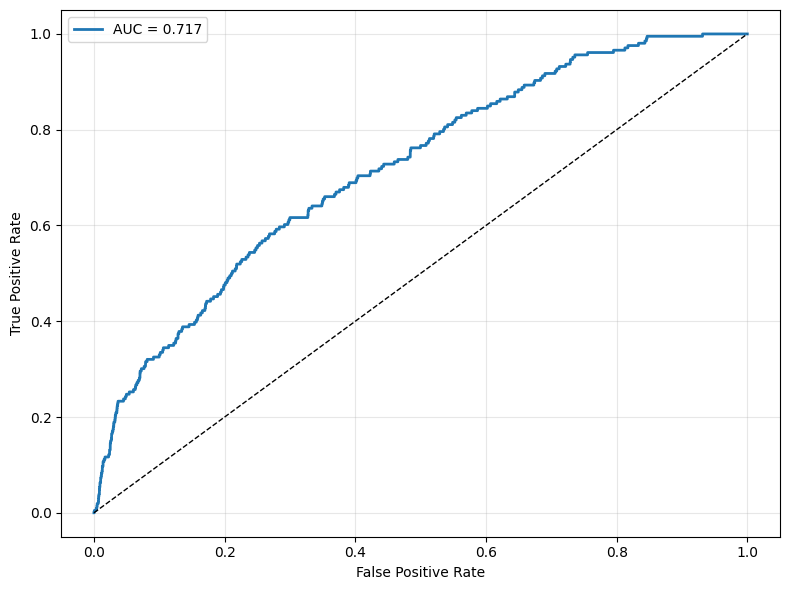

Loss: 1.9939527793623069
===== EPOCH 11 =====


  0%|          | 0/595 [00:00<?, ?it/s]

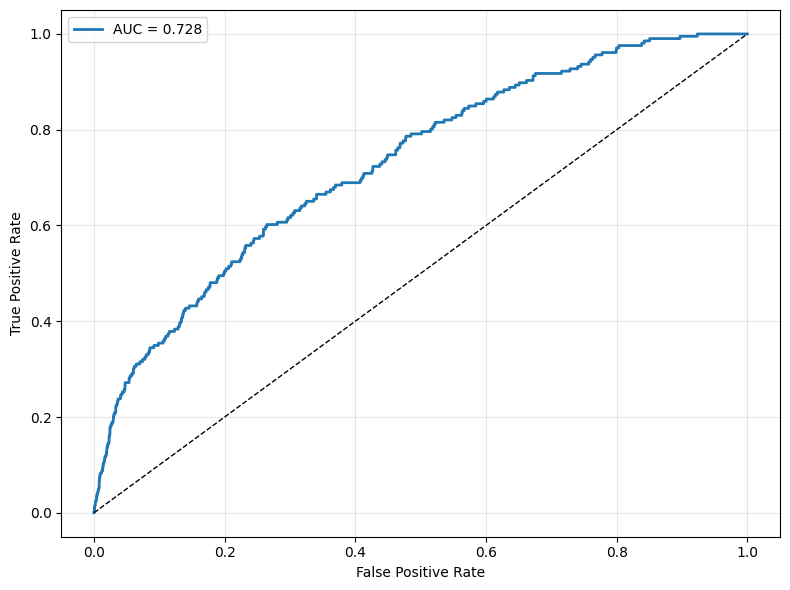

Loss: 1.9894185980891481
===== EPOCH 12 =====


  0%|          | 0/595 [00:00<?, ?it/s]

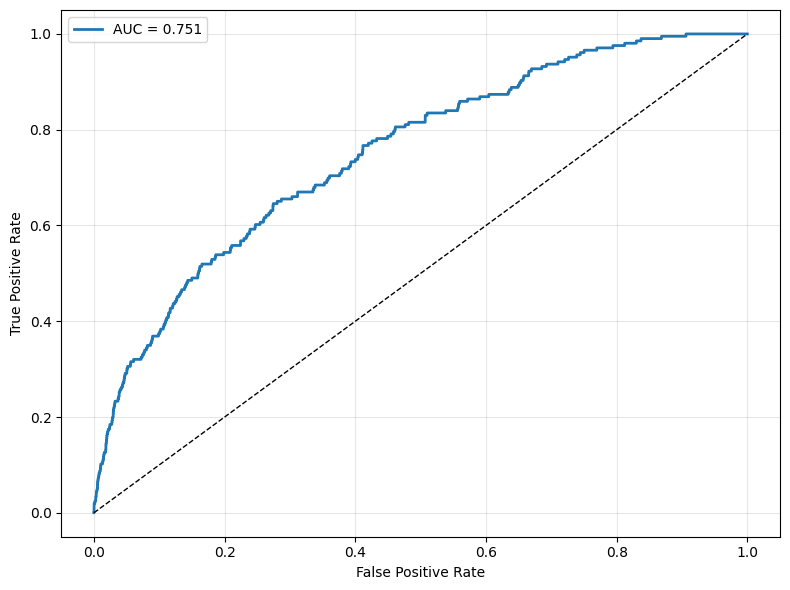

Loss: 1.9864104320647336
===== EPOCH 13 =====


  0%|          | 0/595 [00:00<?, ?it/s]

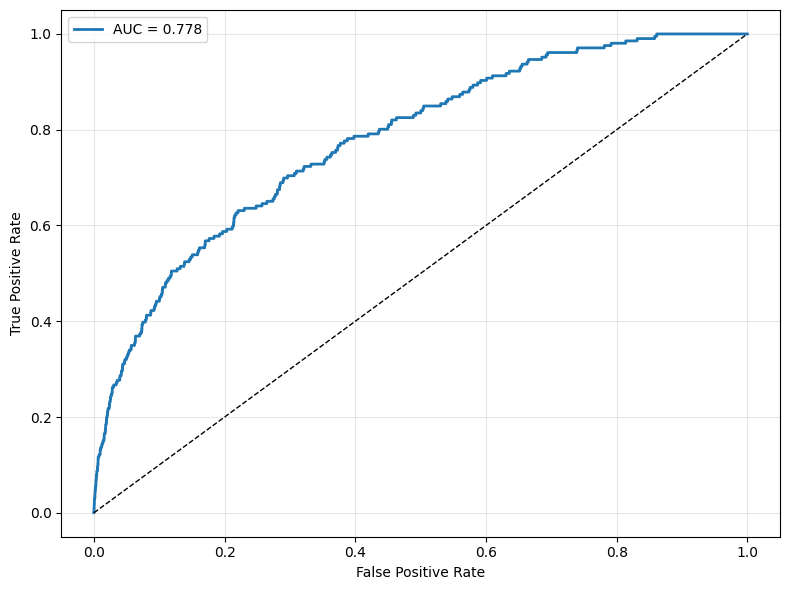

Loss: 1.975486533262399
===== EPOCH 14 =====


  0%|          | 0/595 [00:00<?, ?it/s]

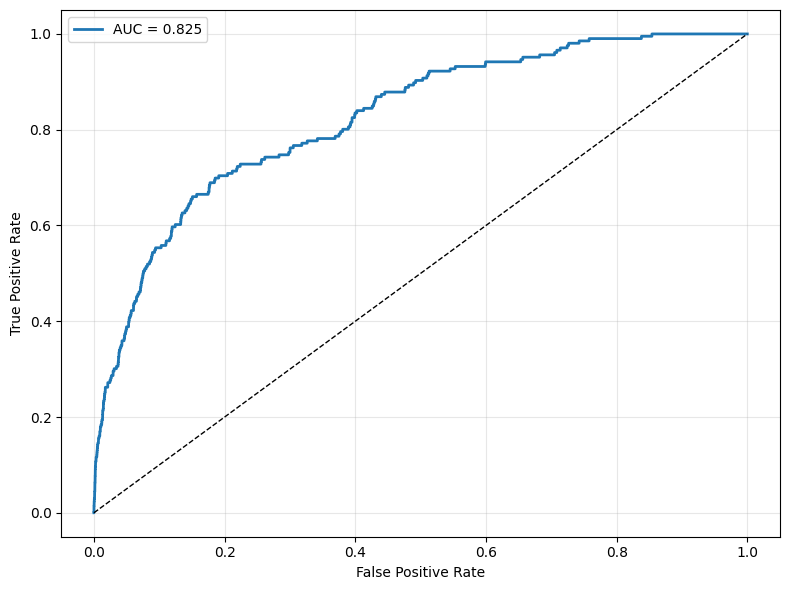

Loss: 1.962468404059901
===== EPOCH 15 =====


  0%|          | 0/595 [00:00<?, ?it/s]

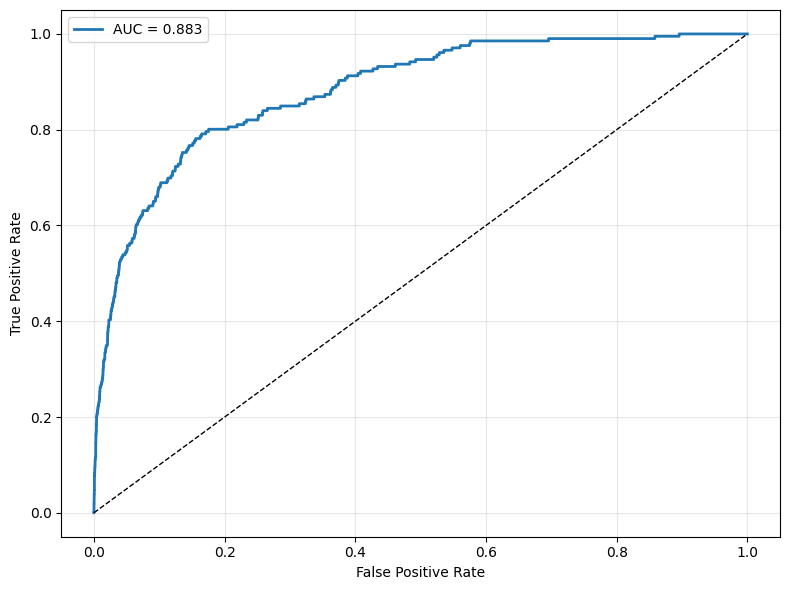

Loss: 1.9370788030451587
===== EPOCH 16 =====


  0%|          | 0/595 [00:00<?, ?it/s]

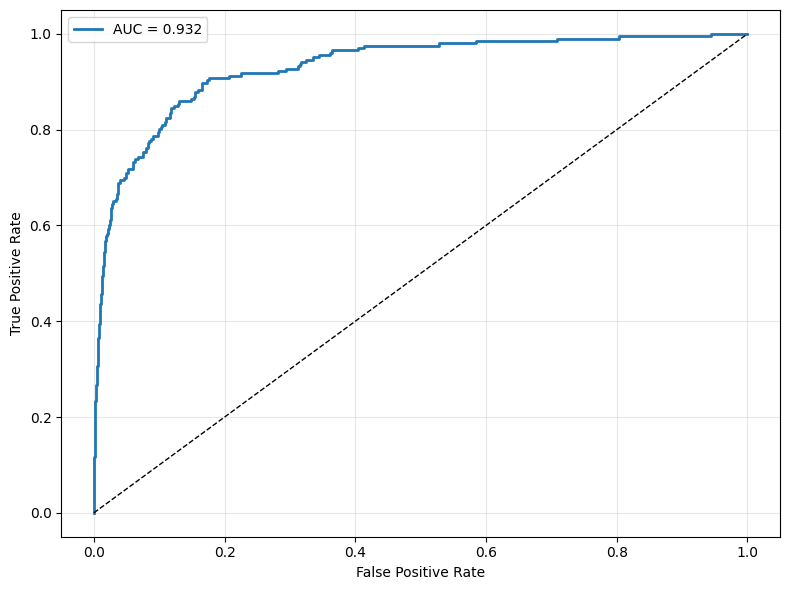

Loss: 1.903088826592229
===== EPOCH 17 =====


  0%|          | 0/595 [00:00<?, ?it/s]

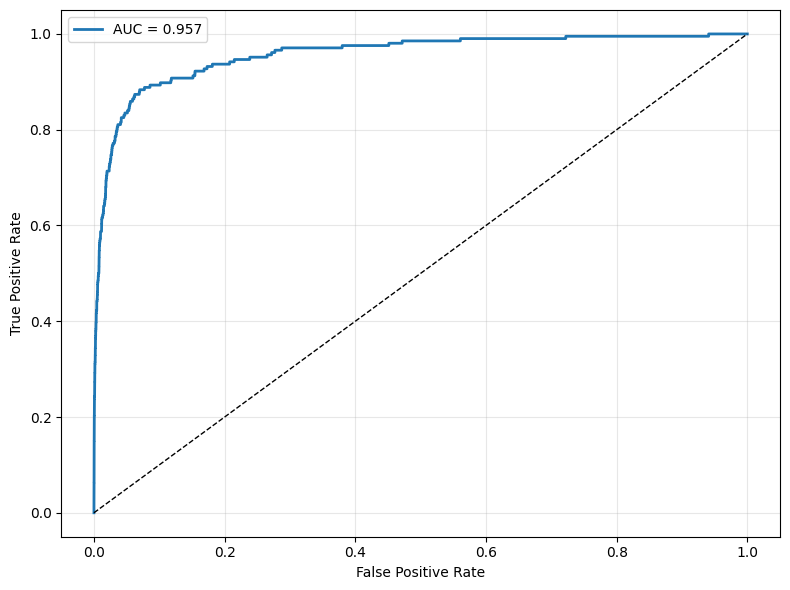

Loss: 1.8588277300240612
===== EPOCH 18 =====


  0%|          | 0/595 [00:00<?, ?it/s]

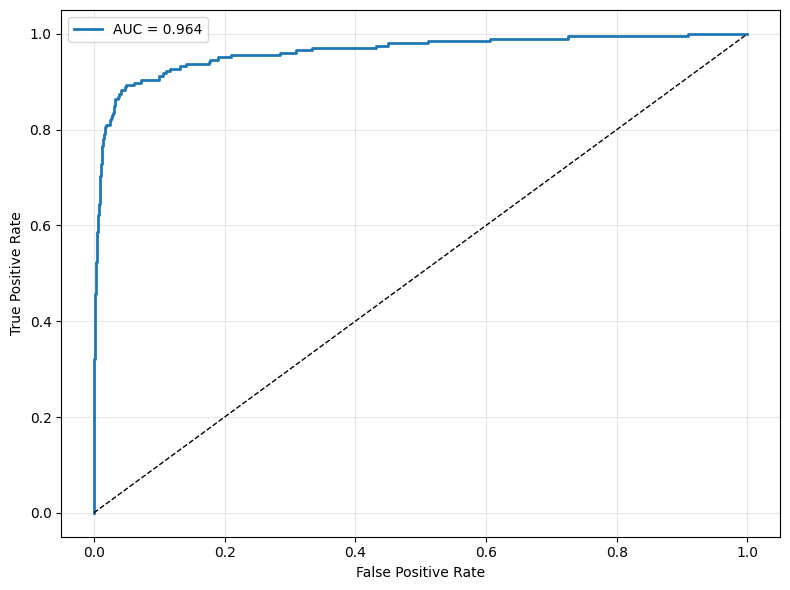

Loss: 1.8286980122327805
===== EPOCH 19 =====


  0%|          | 0/595 [00:00<?, ?it/s]

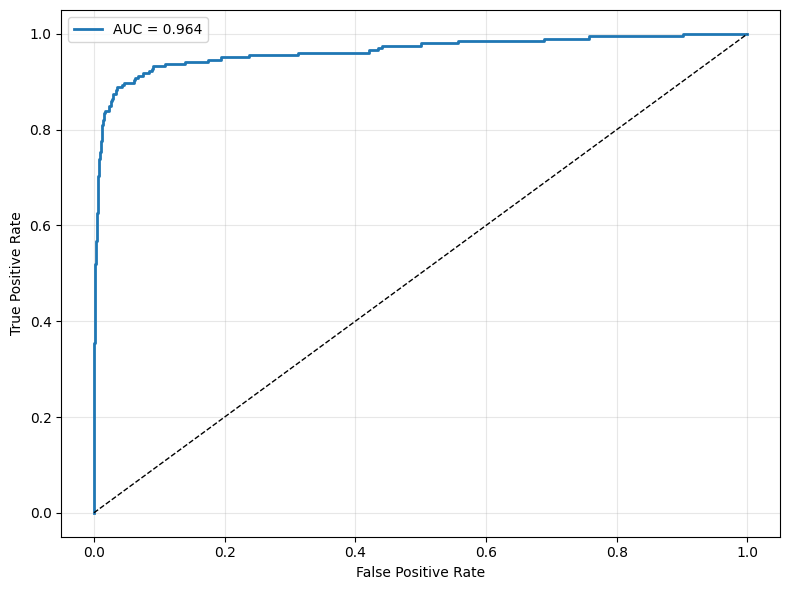

Loss: 1.7914454846822916
===== EPOCH 20 =====


  0%|          | 0/595 [00:00<?, ?it/s]

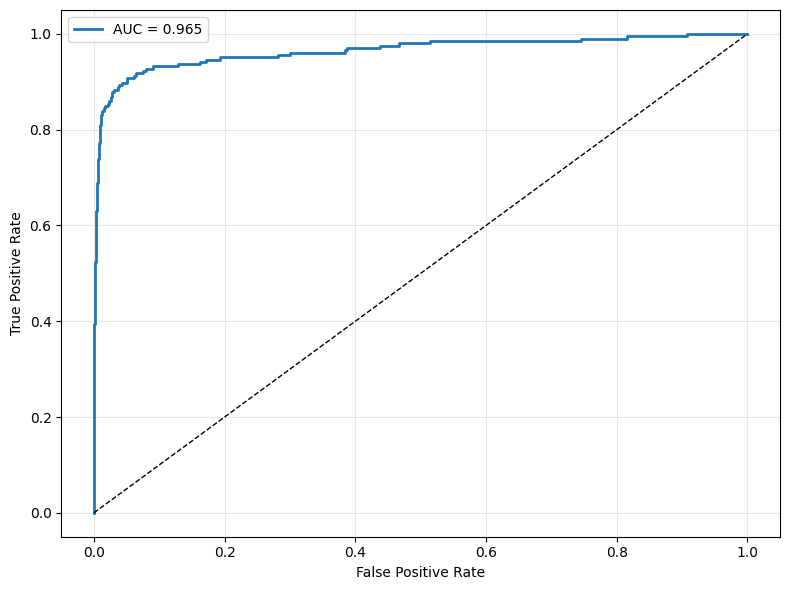

Loss: 1.7917955508753032
===== EPOCH 21 =====


  0%|          | 0/595 [00:00<?, ?it/s]

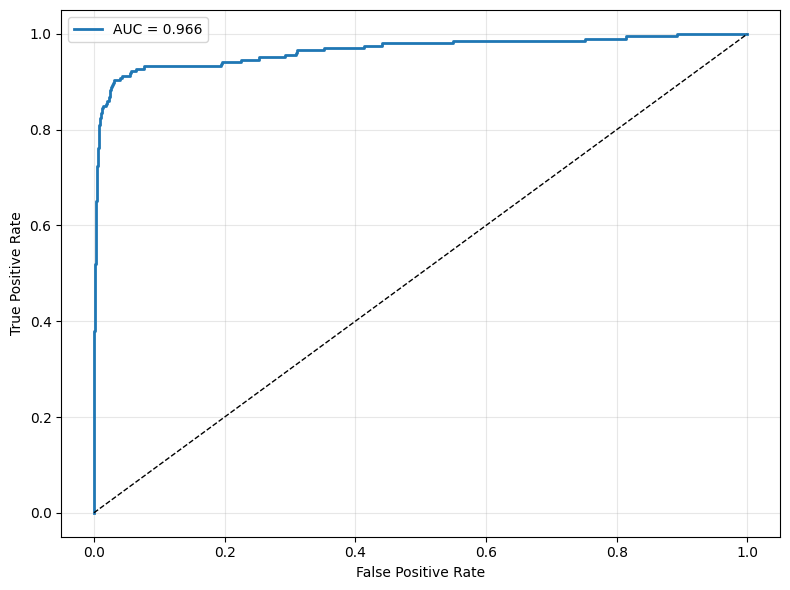

Loss: 1.7571983961998916
===== EPOCH 22 =====


  0%|          | 0/595 [00:00<?, ?it/s]

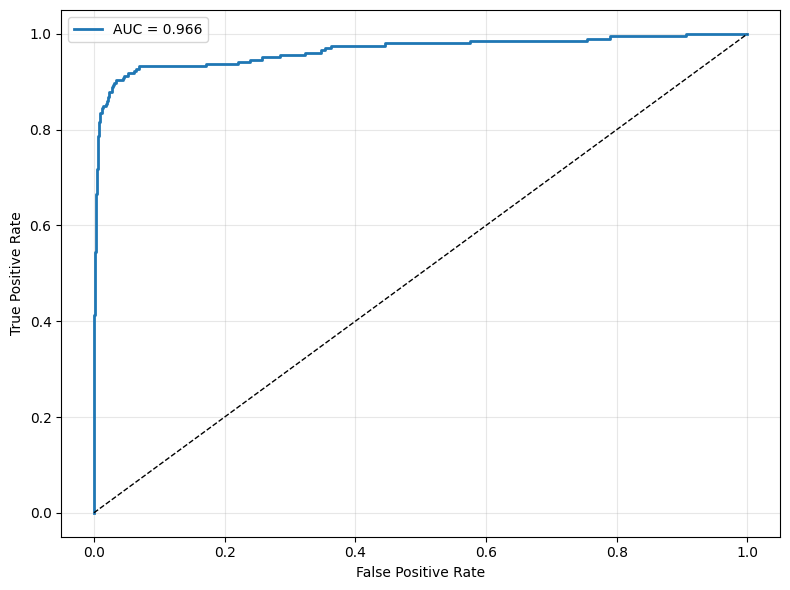

Loss: 1.7531433444814521
===== EPOCH 23 =====


  0%|          | 0/595 [00:00<?, ?it/s]

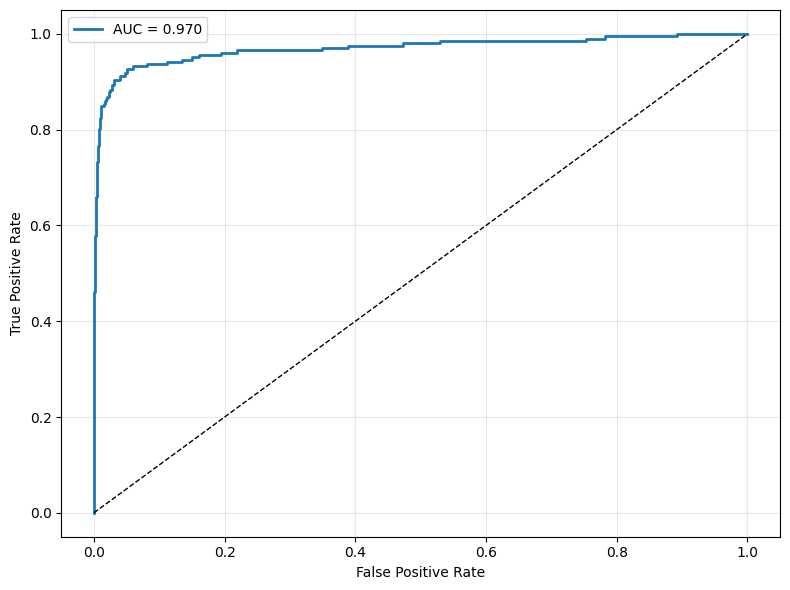

Loss: 1.7380507246473758
===== EPOCH 24 =====


  0%|          | 0/595 [00:00<?, ?it/s]

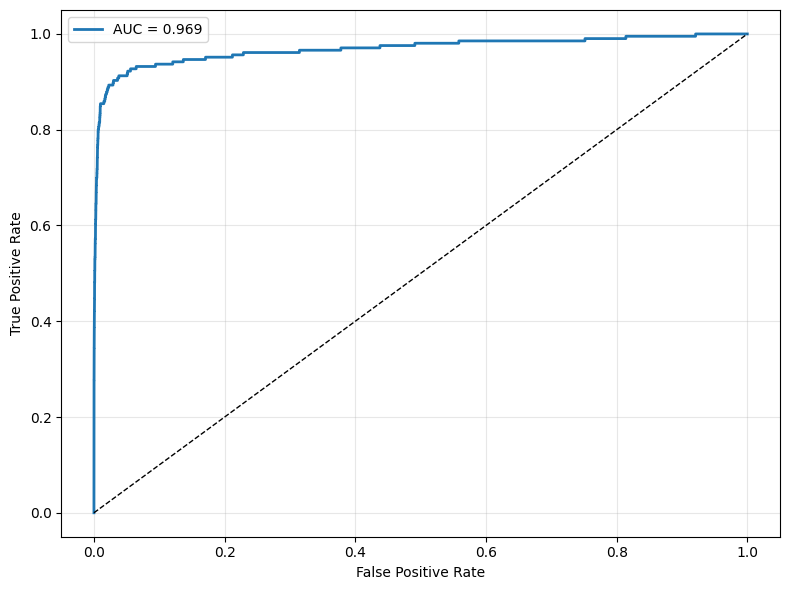

Loss: 1.7186511839888676
===== EPOCH 25 =====


  0%|          | 0/595 [00:00<?, ?it/s]

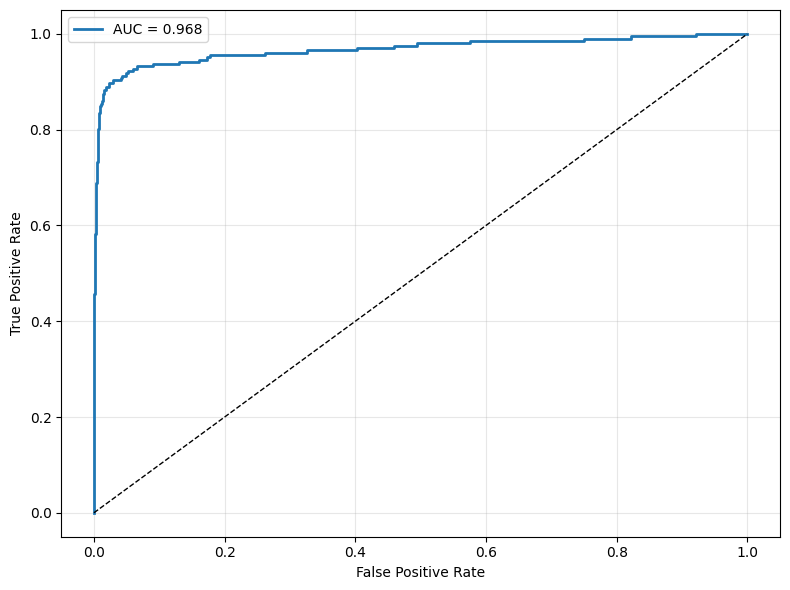

Loss: 1.6935952571009387
===== EPOCH 26 =====


  0%|          | 0/595 [00:00<?, ?it/s]

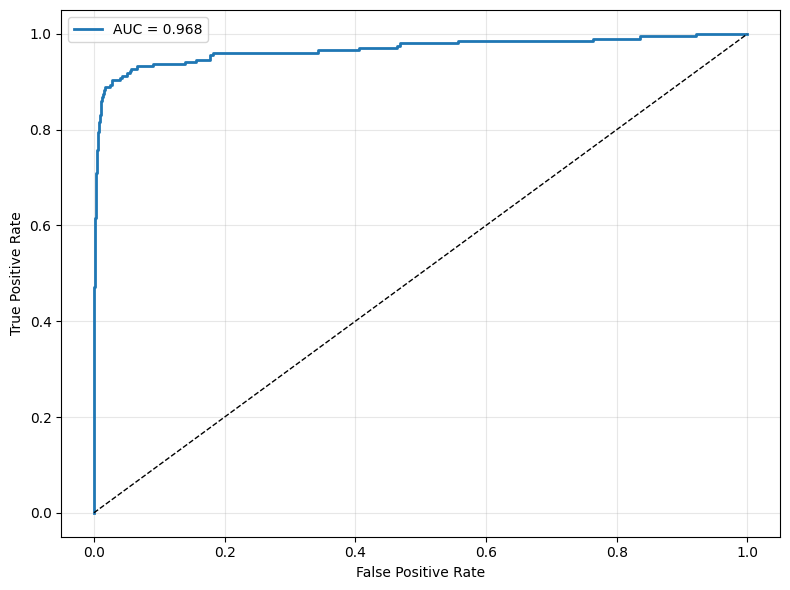

Loss: 1.6835267977241208
===== EPOCH 27 =====


  0%|          | 0/595 [00:00<?, ?it/s]

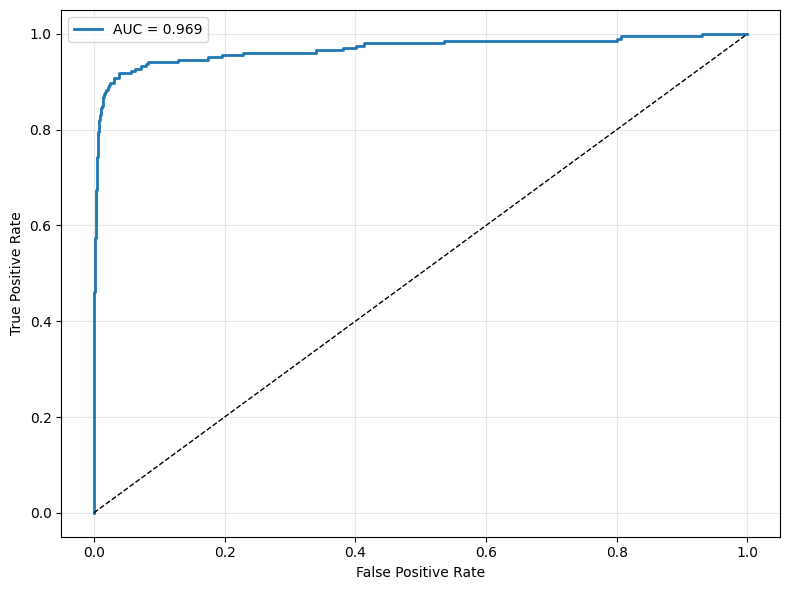

Loss: 1.6789767559586453
===== EPOCH 28 =====


  0%|          | 0/595 [00:00<?, ?it/s]

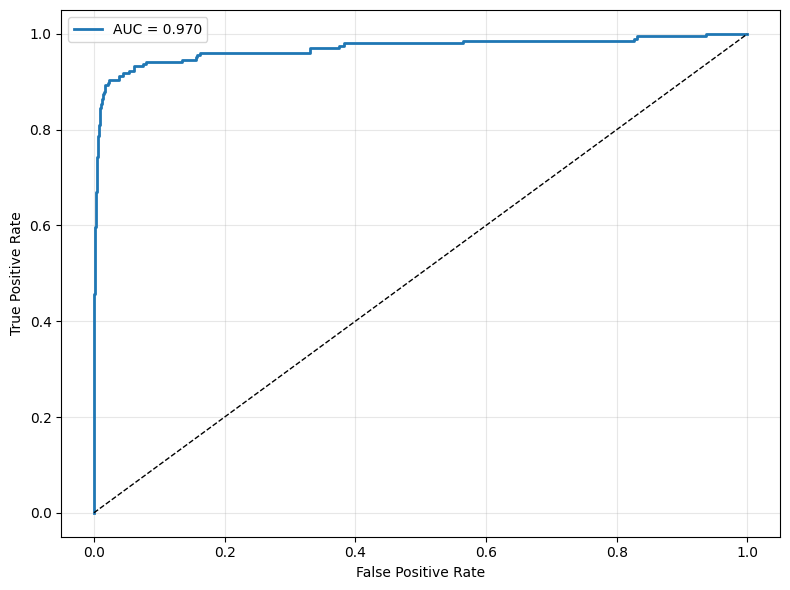

Loss: 1.6641265724699537
===== EPOCH 29 =====


  0%|          | 0/595 [00:00<?, ?it/s]

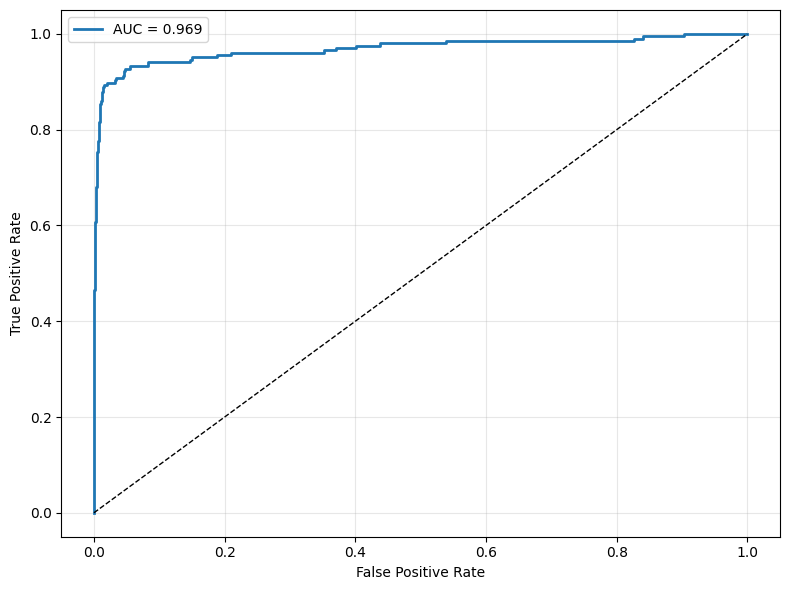

Loss: 1.6615402114741942
===== EPOCH 30 =====


  0%|          | 0/595 [00:00<?, ?it/s]

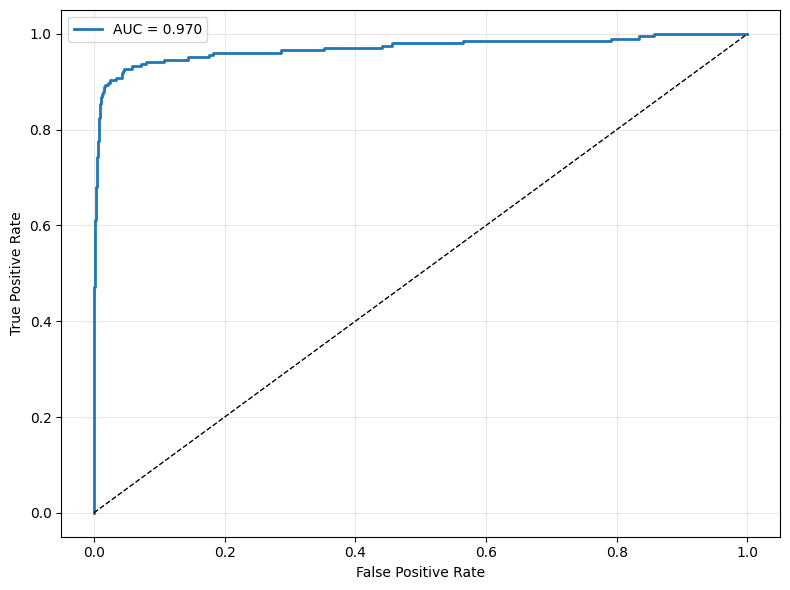

Loss: 1.6416341024349217


In [224]:
train(mw, train_loader, 30)

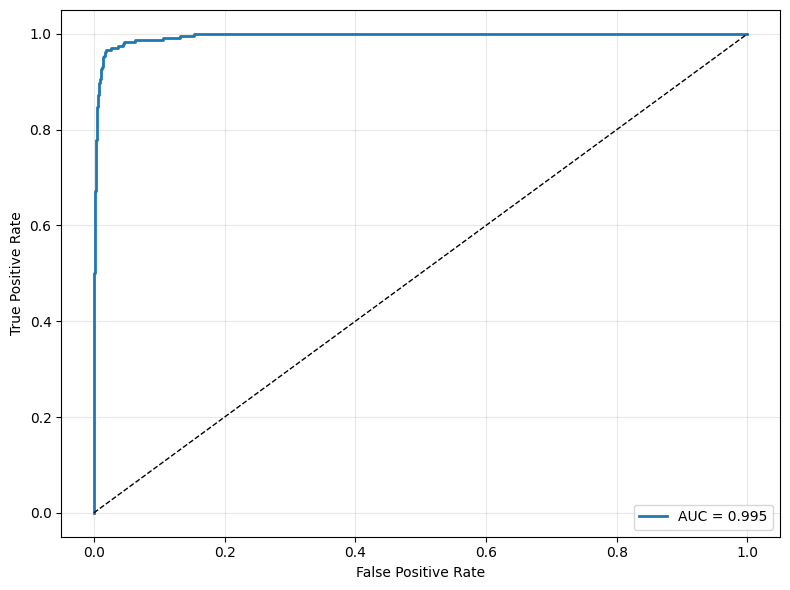

{'pearson': np.float32(0.70180196),
 'spearman': np.float64(0.4824898599707142),
 'auc': np.float64(0.9952664514531251)}

In [225]:
mw.evaluate(x_train, y_train, label_train)

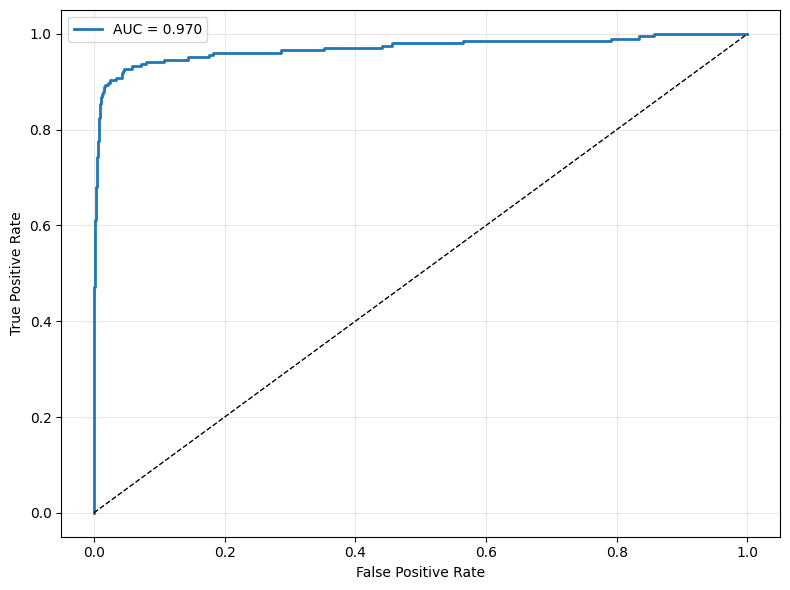

{'pearson': np.float32(0.5695075),
 'spearman': np.float64(0.37095291061220903),
 'auc': np.float64(0.9703249780020018)}

In [226]:
mw.evaluate(x_test, y_test, label_test)